In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

if tf.config.list_physical_devices("GPU"):
    print("GPU found. Mixed precision enabled.")
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

train_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Train_Augmented_21k'
valid_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Valid'
test_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Test'
save_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Revised Results/MobileNetV2'

os.makedirs(save_dir, exist_ok=True)
model_save_dir = os.path.join(save_dir, "model")
plots_save_dir = os.path.join(save_dir, "plots")
os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(plots_save_dir, exist_ok=True)

classes = sorted(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical", shuffle=True
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical"
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical", shuffle=False
)

def create_model():
    base = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)

    out = Dense(len(classes), activation="softmax", dtype="float32")(x)
    model = Model(inputs=base.input, outputs=out)

    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_model()
print(model.summary())

early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(os.path.join(model_save_dir, "best_model.h5"),
                             save_best_only=True, monitor="val_loss", mode="min")

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save(os.path.join(model_save_dir, "final_model.keras"))

test_preds = model.predict(test_generator)
pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes

print("\nPer Class Metrics")
metrics_log = []
for idx, cls in enumerate(classes):
    cls_true = (true_classes == idx)
    cls_pred = (pred_classes == idx)

    cls_precision = precision_score(cls_true, cls_pred)
    cls_recall = recall_score(cls_true, cls_pred)
    cls_f1 = f1_score(cls_true, cls_pred)
    cls_acc = np.mean(cls_pred == cls_true)

    print(f"{cls} -> Accuracy={cls_acc:.4f}, Precision={cls_precision:.4f}, Recall={cls_recall:.4f}, F1={cls_f1:.4f}")

    metrics_log.append([cls, cls_acc, cls_precision, cls_recall, cls_f1])

with open(os.path.join(plots_save_dir, "class_metrics.txt"), "w") as f:
    for a in metrics_log:
        f.write(f"{a[0]}  Acc={a[1]:.4f}  Prec={a[2]:.4f}  Recall={a[3]:.4f}  F1={a[4]:.4f}\n")

plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(true_classes == i, test_preds[:, i])
    plt.plot(fpr, tpr, label=cls)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Class - MobileNetV2")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_save_dir, "roc_curve.png"))
plt.close()

auc = roc_auc_score(true_classes, test_preds, multi_class="ovo")
print("\nOverall ROC AUC:", auc)

boot = []
n = len(true_classes)

for _ in range(200):
    idx = np.random.choice(range(n), size=n, replace=True)
    boot.append(np.mean(pred_classes[idx] == true_classes[idx]))

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])
print(f"\nAccuracy 95% CI: {ci_low:.4f} - {ci_high:.4f}")

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MobileNetV2")
plt.savefig(os.path.join(plots_save_dir, "confusion_matrix.png"))
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend(["Training", "Validation"])
plt.savefig(os.path.join(plots_save_dir, "accuracy.png"))
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend(["Training", "Validation"])
plt.savefig(os.path.join(plots_save_dir, "loss.png"))
plt.close()

print("\nTraining complete. Metrics, ROC, confusion matrix saved.")


Found 21358 images belonging to 7 classes.
Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 3,576,903 (13.64 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5336 - loss: 1.3079

668/668 ━━━━━━━━━━━━━━━━━━━━ 228s 338ms/step - accuracy: 0.6745 - loss: 0.9302 - val_accuracy: 0.6886 - val_loss: 0.8862 - learning_rate: 1.0000e-04
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8540 - loss: 0.4609

668/668 ━━━━━━━━━━━━━━━━━━━━ 261s 336ms/step - accuracy: 0.8709 - loss: 0.4137 - val_accuracy: 0.7571 - val_loss: 0.7372 - learning_rate: 1.0000e-04
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9162 - loss: 0.2873

668/668 ━━━━━━━━━━━━━━━━━━━━ 198s 295ms/step - accuracy: 0.9217 - loss: 0.2673 - val_accuracy: 0.7743 - val_loss: 0.6967 - learning_rate: 1.0000e-04
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9427 - loss: 0.2035

668/668 ━━━━━━━━━━━━━━━━━━━━ 231s 339ms/step - accuracy: 0.9449 - loss: 0.1937 - val_accuracy: 0.8029 - val_loss: 0.6392 - learning_rate: 1.0000e-04
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9596 - loss: 0.1526

668/668 ━━━━━━━━━━━━━━━━━━━━ 224s 335ms/step - accuracy: 0.9596 - loss: 0.1486 - val_accuracy: 0.8114 - val_loss: 0.5768 - learning_rate: 1.0000e-04
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 240s 360ms/step - accuracy: 0.9657 - loss: 0.1214 - val_accuracy: 0.8114 - val_loss: 0.5837 - learning_rate: 1.0000e-04
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9722 - loss: 0.1049

668/668 ━━━━━━━━━━━━━━━━━━━━ 249s 372ms/step - accuracy: 0.9732 - loss: 0.0991 - val_accuracy: 0.8229 - val_loss: 0.5392 - learning_rate: 1.0000e-04
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 260s 370ms/step - accuracy: 0.9779 - loss: 0.0812 - val_accuracy: 0.8343 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 9/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9798 - loss: 0.0771

668/668 ━━━━━━━━━━━━━━━━━━━━ 230s 344ms/step - accuracy: 0.9809 - loss: 0.0714 - val_accuracy: 0.8600 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 10/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 268s 352ms/step - accuracy: 0.9834 - loss: 0.0615 - val_accuracy: 0.8400 - val_loss: 0.5192 - learning_rate: 1.0000e-04
Epoch 11/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 253s 339ms/step - accuracy: 0.9873 - loss: 0.0523 - val_accuracy: 0.8629 - val_loss: 0.4609 - learning_rate: 1.0000e-04
Epoch 12/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 227s 339ms/step - accuracy: 0.9869 - loss: 0.0482 - val_accuracy: 0.8743 - val_loss: 0.4418 - learning_rate: 1.0000e-04
Epoch 13/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 227s 339ms/step - accuracy: 0.9904 - loss: 0.0386 - val_accuracy: 0.8571 - val_loss: 0.4653 - learning_rate: 1.0000e-05
Epoch 14/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 221s 331ms/step - accuracy: 0.9924 - loss: 0.0343 - val_accuracy: 0.8514 - val_loss: 0.4640 - learning_rate: 1.0000e-05
Epoch 15/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 231s 

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.densenet import preprocess_input

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

if tf.config.list_physical_devices("GPU"):
    print("GPU detected. Mixed precision enabled.")
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

train_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Train_Augmented_21k'
valid_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Valid'
test_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Test'
save_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Revised Results/DenseNet121'

os.makedirs(save_dir, exist_ok=True)
model_save_dir = os.path.join(save_dir, "model")
plots_save_dir = os.path.join(save_dir, "plots")
os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(plots_save_dir, exist_ok=True)

classes = sorted(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical", shuffle=True
)
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical"
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical", shuffle=False
)

def create_model():
    base = DenseNet121(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)

    out = Dense(len(classes), activation="softmax", dtype="float32")(x)
    model = Model(inputs=base.input, outputs=out)

    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_model()
print(model.summary())

early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(os.path.join(model_save_dir, "best_densenet_model.h5"),
                             save_best_only=True, monitor="val_loss", mode="min")
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save(os.path.join(model_save_dir, "final_densenet_model.keras"))

test_preds = model.predict(test_generator)
pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes

print("\nPer Class Metrics")
metrics_log = []
for idx, cls in enumerate(classes):
    cls_true = (true_classes == idx)
    cls_pred = (pred_classes == idx)

    cls_precision = precision_score(cls_true, cls_pred)
    cls_recall = recall_score(cls_true, cls_pred)
    cls_f1 = f1_score(cls_true, cls_pred)
    cls_acc = np.mean(cls_pred == cls_true)

    print(f"{cls} -> Accuracy={cls_acc:.4f}, Precision={cls_precision:.4f}, Recall={cls_recall:.4f}, F1={cls_f1:.4f}")
    metrics_log.append([cls, cls_acc, cls_precision, cls_recall, cls_f1])

with open(os.path.join(plots_save_dir, "densenet_class_metrics.txt"), "w") as f:
    for m in metrics_log:
        f.write(f"{m[0]}  Acc={m[1]:.4f}  Prec={m[2]:.4f}  Recall={m[3]:.4f}  F1={m[4]:.4f}\n")

plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(true_classes == i, test_preds[:, i])
    plt.plot(fpr, tpr, label=cls)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve per Class – DenseNet121")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_save_dir, "densenet_roc_curve.png"))
plt.close()

auc = roc_auc_score(true_classes, test_preds, multi_class="ovo")
print("\nOverall ROC AUC:", auc)

boot = []
n = len(true_classes)
for _ in range(200):
    idx = np.random.choice(range(n), size=n, replace=True)
    boot.append(np.mean(pred_classes[idx] == true_classes[idx]))

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])
print(f"\nAccuracy 95% CI: {ci_low:.4f} - {ci_high:.4f}")

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix – DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(plots_save_dir, "densenet_confusion_matrix.png"))
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs – DenseNet121")
plt.legend(["Training", "Validation"])
plt.savefig(os.path.join(plots_save_dir, "densenet_accuracy.png"))
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs – DenseNet121")
plt.legend(["Training", "Validation"])
plt.savefig(os.path.join(plots_save_dir, "densenet_loss.png"))
plt.close()

print("\nDenseNet121 Training complete. Metrics and plots saved.")


Found 21358 images belonging to 7 classes.
Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 8,094,279 (30.88 MB)

 Trainable params: 1,056,775 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

None
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4551 - loss: 1.7246

668/668 ━━━━━━━━━━━━━━━━━━━━ 248s 362ms/step - accuracy: 0.6000 - loss: 1.1771 - val_accuracy: 0.7257 - val_loss: 0.7799 - learning_rate: 1.0000e-04
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8043 - loss: 0.5809

668/668 ━━━━━━━━━━━━━━━━━━━━ 318s 476ms/step - accuracy: 0.8277 - loss: 0.5213 - val_accuracy: 0.8257 - val_loss: 0.5422 - learning_rate: 1.0000e-04
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8780 - loss: 0.3810

668/668 ━━━━━━━━━━━━━━━━━━━━ 781s 1s/step - accuracy: 0.8877 - loss: 0.3519 - val_accuracy: 0.8400 - val_loss: 0.5127 - learning_rate: 1.0000e-04
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9146 - loss: 0.2754

668/668 ━━━━━━━━━━━━━━━━━━━━ 891s 1s/step - accuracy: 0.9206 - loss: 0.2599 - val_accuracy: 0.8629 - val_loss: 0.4204 - learning_rate: 1.0000e-04
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9378 - loss: 0.2131

668/668 ━━━━━━━━━━━━━━━━━━━━ 561s 839ms/step - accuracy: 0.9408 - loss: 0.1971 - val_accuracy: 0.8714 - val_loss: 0.4024 - learning_rate: 1.0000e-04
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9511 - loss: 0.1639

668/668 ━━━━━━━━━━━━━━━━━━━━ 193s 288ms/step - accuracy: 0.9525 - loss: 0.1577 - val_accuracy: 0.8714 - val_loss: 0.3812 - learning_rate: 1.0000e-04
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9582 - loss: 0.1378

668/668 ━━━━━━━━━━━━━━━━━━━━ 186s 279ms/step - accuracy: 0.9594 - loss: 0.1343 - val_accuracy: 0.8971 - val_loss: 0.3202 - learning_rate: 1.0000e-04
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 247s 369ms/step - accuracy: 0.9685 - loss: 0.1103 - val_accuracy: 0.8971 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 9/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 206s 308ms/step - accuracy: 0.9725 - loss: 0.0956 - val_accuracy: 0.8943 - val_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 10/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9738 - loss: 0.0885

668/668 ━━━━━━━━━━━━━━━━━━━━ 199s 298ms/step - accuracy: 0.9736 - loss: 0.0882 - val_accuracy: 0.9229 - val_loss: 0.2664 - learning_rate: 1.0000e-04
Epoch 11/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 216s 323ms/step - accuracy: 0.9791 - loss: 0.0738 - val_accuracy: 0.9171 - val_loss: 0.2678 - learning_rate: 1.0000e-04
Epoch 12/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9797 - loss: 0.0691

668/668 ━━━━━━━━━━━━━━━━━━━━ 213s 318ms/step - accuracy: 0.9795 - loss: 0.0688 - val_accuracy: 0.9229 - val_loss: 0.2541 - learning_rate: 1.0000e-04
Epoch 13/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 211s 316ms/step - accuracy: 0.9843 - loss: 0.0585 - val_accuracy: 0.9200 - val_loss: 0.2613 - learning_rate: 1.0000e-04
Epoch 14/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9846 - loss: 0.0538

668/668 ━━━━━━━━━━━━━━━━━━━━ 217s 324ms/step - accuracy: 0.9845 - loss: 0.0550 - val_accuracy: 0.9143 - val_loss: 0.2450 - learning_rate: 1.0000e-04
Epoch 15/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 213s 319ms/step - accuracy: 0.9859 - loss: 0.0488 - val_accuracy: 0.9229 - val_loss: 0.2609 - learning_rate: 1.0000e-04
Epoch 16/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 200s 299ms/step - accuracy: 0.9876 - loss: 0.0446 - val_accuracy: 0.9171 - val_loss: 0.2556 - learning_rate: 1.0000e-04
Epoch 17/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9867 - loss: 0.0455

668/668 ━━━━━━━━━━━━━━━━━━━━ 193s 288ms/step - accuracy: 0.9873 - loss: 0.0442 - val_accuracy: 0.9286 - val_loss: 0.2113 - learning_rate: 1.0000e-04
Epoch 18/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 191s 286ms/step - accuracy: 0.9882 - loss: 0.0390 - val_accuracy: 0.9171 - val_loss: 0.2814 - learning_rate: 1.0000e-04
Epoch 19/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 197s 295ms/step - accuracy: 0.9891 - loss: 0.0372 - val_accuracy: 0.9286 - val_loss: 0.2338 - learning_rate: 1.0000e-04
Epoch 20/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 194s 290ms/step - accuracy: 0.9909 - loss: 0.0339 - val_accuracy: 0.9171 - val_loss: 0.2552 - learning_rate: 1.0000e-04
Epoch 21/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 196s 293ms/step - accuracy: 0.9921 - loss: 0.0293 - val_accuracy: 0.9343 - val_loss: 0.2178 - learning_rate: 1.0000e-05
Epoch 22/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 192s 287ms/step - accuracy: 0.9934 - loss: 0.0250 - val_accuracy: 0.9314 - val_loss: 0.2258 - learning_rate: 1.0000e-05
Epoch 23/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 199s 

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import regularizers

from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

if tf.config.list_physical_devices("GPU"):
    print("GPU detected. Mixed precision enabled.")
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

train_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Train_Augmented_21k'
valid_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Valid'
test_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Test'
save_dir = 'K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Revised Results/VGG16'

os.makedirs(save_dir, exist_ok=True)
model_save_dir = os.path.join(save_dir, "model")
plots_save_dir = os.path.join(save_dir, "plots")
os.makedirs(model_save_dir, exist_ok=True)
os.makedirs(plots_save_dir, exist_ok=True)

classes = sorted(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical", shuffle=True
)
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical"
)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir, target_size=(128, 128), batch_size=32,
    class_mode="categorical", shuffle=False
)

def create_model():
    base = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)

    out = Dense(len(classes), activation="softmax", dtype="float32")(x)
    model = Model(inputs=base.input, outputs=out)

    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_model()
print(model.summary())

early_stopping = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint(os.path.join(model_save_dir, "best_vgg16_model.h5"),
                             save_best_only=True, monitor="val_loss", mode="min")
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save(os.path.join(model_save_dir, "final_vgg16_model.keras"))

test_preds = model.predict(test_generator)
pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes

metrics_log = []
print("\nPer Class Metrics")
for idx, cls in enumerate(classes):
    cls_true = (true_classes == idx)
    cls_pred = (pred_classes == idx)

    cls_precision = precision_score(cls_true, cls_pred)
    cls_recall = recall_score(cls_true, cls_pred)
    cls_f1 = f1_score(cls_true, cls_pred)
    cls_acc = np.mean(cls_pred == cls_true)

    print(f"{cls} -> Accuracy={cls_acc:.4f}, Precision={cls_precision:.4f}, Recall={cls_recall:.4f}, F1={cls_f1:.4f}")
    metrics_log.append([cls, cls_acc, cls_precision, cls_recall, cls_f1])

with open(os.path.join(plots_save_dir, "vgg16_class_metrics.txt"), "w") as f:
    for m in metrics_log:
        f.write(f"{m[0]}  Acc={m[1]:.4f}  Prec={m[2]:.4f}  Recall={m[3]:.4f}  F1={m[4]:.4f}\n")

plt.figure(figsize=(10, 8))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(true_classes == i, test_preds[:, i])
    plt.plot(fpr, tpr, label=cls)

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curve per Class – VGG16")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(plots_save_dir, "vgg16_roc_curve.png"))
plt.close()

auc = roc_auc_score(true_classes, test_preds, multi_class="ovo")
print("\nOverall ROC AUC:", auc)

boot = []
n = len(true_classes)
for _ in range(200):
    idx = np.random.choice(range(n), size=n, replace=True)
    boot.append(np.mean(pred_classes[idx] == true_classes[idx]))

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])
print(f"\nAccuracy 95% CI: {ci_low:.4f} - {ci_high:.4f}")

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix – VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig(os.path.join(plots_save_dir, "vgg16_confusion_matrix.png"))
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs – VGG16")
plt.legend(["Training", "Validation"])
plt.savefig(os.path.join(plots_save_dir, "vgg16_accuracy.png"))
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs – VGG16")
plt.legend(["Training", "Validation"])
plt.savefig(os.path.join(plots_save_dir, "vgg16_loss.png"))
plt.close()

print("\nVGG16 Training complete. Metrics and plots saved.")


Found 21358 images belonging to 7 classes.
Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,247,175 (58.16 MB)

 Trainable params: 532,487 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None
Epoch 1/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 700ms/step - accuracy: 0.4226 - loss: 10.9722

668/668 ━━━━━━━━━━━━━━━━━━━━ 476s 712ms/step - accuracy: 0.5553 - loss: 9.1013 - val_accuracy: 0.7000 - val_loss: 7.3924 - learning_rate: 1.0000e-04
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.7618 - loss: 6.7504

668/668 ━━━━━━━━━━━━━━━━━━━━ 510s 764ms/step - accuracy: 0.7914 - loss: 6.4287 - val_accuracy: 0.8086 - val_loss: 5.9905 - learning_rate: 1.0000e-04
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8516 - loss: 5.5569

668/668 ━━━━━━━━━━━━━━━━━━━━ 1779s 3s/step - accuracy: 0.8667 - loss: 5.3056 - val_accuracy: 0.8171 - val_loss: 5.1163 - learning_rate: 1.0000e-04
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9042 - loss: 4.5694

668/668 ━━━━━━━━━━━━━━━━━━━━ 424s 635ms/step - accuracy: 0.9067 - loss: 4.3505 - val_accuracy: 0.8829 - val_loss: 4.0353 - learning_rate: 1.0000e-04
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9310 - loss: 3.7007

668/668 ━━━━━━━━━━━━━━━━━━━━ 450s 673ms/step - accuracy: 0.9335 - loss: 3.5025 - val_accuracy: 0.9143 - val_loss: 3.2451 - learning_rate: 1.0000e-04
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.9481 - loss: 2.9221

668/668 ━━━━━━━━━━━━━━━━━━━━ 466s 697ms/step - accuracy: 0.9479 - loss: 2.7649 - val_accuracy: 0.8800 - val_loss: 2.6865 - learning_rate: 1.0000e-04
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9554 - loss: 2.2857

668/668 ━━━━━━━━━━━━━━━━━━━━ 444s 665ms/step - accuracy: 0.9578 - loss: 2.1475 - val_accuracy: 0.9200 - val_loss: 2.0250 - learning_rate: 1.0000e-04
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 664ms/step - accuracy: 0.9688 - loss: 1.7540

668/668 ━━━━━━━━━━━━━━━━━━━━ 452s 677ms/step - accuracy: 0.9679 - loss: 1.6478 - val_accuracy: 0.9086 - val_loss: 1.7008 - learning_rate: 1.0000e-04
Epoch 9/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9691 - loss: 1.3533

668/668 ━━━━━━━━━━━━━━━━━━━━ 794s 1s/step - accuracy: 0.9714 - loss: 1.2671 - val_accuracy: 0.9371 - val_loss: 1.2250 - learning_rate: 1.0000e-04
Epoch 10/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9727 - loss: 1.0513

668/668 ━━━━━━━━━━━━━━━━━━━━ 2346s 4s/step - accuracy: 0.9734 - loss: 0.9855 - val_accuracy: 0.9000 - val_loss: 1.0568 - learning_rate: 1.0000e-04
Epoch 11/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9779 - loss: 0.8134

668/668 ━━━━━━━━━━━━━━━━━━━━ 2407s 4s/step - accuracy: 0.9788 - loss: 0.7698 - val_accuracy: 0.9286 - val_loss: 0.8606 - learning_rate: 1.0000e-04
Epoch 12/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9794 - loss: 0.6469

668/668 ━━━━━━━━━━━━━━━━━━━━ 2439s 4s/step - accuracy: 0.9801 - loss: 0.6144 - val_accuracy: 0.9486 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 13/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9835 - loss: 0.5191

668/668 ━━━━━━━━━━━━━━━━━━━━ 2761s 4s/step - accuracy: 0.9817 - loss: 0.5004 - val_accuracy: 0.9086 - val_loss: 0.6311 - learning_rate: 1.0000e-04
Epoch 14/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9830 - loss: 0.4348

668/668 ━━━━━━━━━━━━━━━━━━━━ 1489s 2s/step - accuracy: 0.9820 - loss: 0.4217 - val_accuracy: 0.9400 - val_loss: 0.4929 - learning_rate: 1.0000e-04
Epoch 15/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 496s 743ms/step - accuracy: 0.9822 - loss: 0.3612 - val_accuracy: 0.9400 - val_loss: 0.5206 - learning_rate: 1.0000e-04
Epoch 16/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 529s 792ms/step - accuracy: 0.9836 - loss: 0.3162 - val_accuracy: 0.8800 - val_loss: 0.6031 - learning_rate: 1.0000e-04
Epoch 17/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9853 - loss: 0.2875

668/668 ━━━━━━━━━━━━━━━━━━━━ 559s 837ms/step - accuracy: 0.9835 - loss: 0.2851 - val_accuracy: 0.9371 - val_loss: 0.3833 - learning_rate: 1.0000e-04
Epoch 18/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 537s 803ms/step - accuracy: 0.9852 - loss: 0.2549 - val_accuracy: 0.9229 - val_loss: 0.4421 - learning_rate: 1.0000e-04
Epoch 19/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 556s 832ms/step - accuracy: 0.9835 - loss: 0.2429 - val_accuracy: 0.9314 - val_loss: 0.3837 - learning_rate: 1.0000e-04
Epoch 20/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 984s 1s/step - accuracy: 0.9839 - loss: 0.2283 - val_accuracy: 0.9257 - val_loss: 0.3913 - learning_rate: 1.0000e-04
Epoch 21/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9892 - loss: 0.2056

668/668 ━━━━━━━━━━━━━━━━━━━━ 1508s 2s/step - accuracy: 0.9917 - loss: 0.1989 - val_accuracy: 0.9400 - val_loss: 0.3482 - learning_rate: 1.0000e-05
Epoch 22/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9934 - loss: 0.1884

668/668 ━━━━━━━━━━━━━━━━━━━━ 2477s 4s/step - accuracy: 0.9937 - loss: 0.1865 - val_accuracy: 0.9429 - val_loss: 0.3356 - learning_rate: 1.0000e-05
Epoch 23/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9942 - loss: 0.1794

668/668 ━━━━━━━━━━━━━━━━━━━━ 2907s 4s/step - accuracy: 0.9945 - loss: 0.1775 - val_accuracy: 0.9429 - val_loss: 0.3073 - learning_rate: 1.0000e-05
Epoch 24/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 2754s 4s/step - accuracy: 0.9949 - loss: 0.1714 - val_accuracy: 0.9457 - val_loss: 0.3073 - learning_rate: 1.0000e-05
Epoch 25/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9952 - loss: 0.1666

668/668 ━━━━━━━━━━━━━━━━━━━━ 1190s 2s/step - accuracy: 0.9948 - loss: 0.1662 - val_accuracy: 0.9486 - val_loss: 0.3004 - learning_rate: 1.0000e-05
Epoch 26/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 579s 867ms/step - accuracy: 0.9945 - loss: 0.1607 - val_accuracy: 0.9486 - val_loss: 0.3009 - learning_rate: 1.0000e-05
Epoch 27/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 846ms/step - accuracy: 0.9946 - loss: 0.1554

668/668 ━━━━━━━━━━━━━━━━━━━━ 575s 860ms/step - accuracy: 0.9948 - loss: 0.1546 - val_accuracy: 0.9486 - val_loss: 0.2883 - learning_rate: 1.0000e-05
Epoch 28/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.9956 - loss: 0.1497

668/668 ━━━━━━━━━━━━━━━━━━━━ 572s 856ms/step - accuracy: 0.9956 - loss: 0.1497 - val_accuracy: 0.9429 - val_loss: 0.2804 - learning_rate: 1.0000e-05
Epoch 29/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 586s 877ms/step - accuracy: 0.9961 - loss: 0.1445 - val_accuracy: 0.9457 - val_loss: 0.2864 - learning_rate: 1.0000e-05
Epoch 30/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 574s 859ms/step - accuracy: 0.9956 - loss: 0.1416 - val_accuracy: 0.9429 - val_loss: 0.2909 - learning_rate: 1.0000e-05
Epoch 31/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 491s 735ms/step - accuracy: 0.9954 - loss: 0.1373 - val_accuracy: 0.9400 - val_loss: 0.3021 - learning_rate: 1.0000e-05
Epoch 32/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 444s 665ms/step - accuracy: 0.9962 - loss: 0.1350 - val_accuracy: 0.9429 - val_loss: 0.2887 - learning_rate: 1.0000e-06
Epoch 33/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 423s 633ms/step - accuracy: 0.9959 - loss: 0.1341 - val_accuracy: 0.9429 - val_loss: 0.2807 - learning_rate: 1.0000e-06
Epoch 34/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 70

668/668 ━━━━━━━━━━━━━━━━━━━━ 481s 721ms/step - accuracy: 0.9959 - loss: 0.1335 - val_accuracy: 0.9429 - val_loss: 0.2788 - learning_rate: 1.0000e-06
Epoch 35/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 498s 746ms/step - accuracy: 0.9955 - loss: 0.1341 - val_accuracy: 0.9400 - val_loss: 0.2869 - learning_rate: 1.0000e-06
Epoch 36/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 517s 774ms/step - accuracy: 0.9957 - loss: 0.1329 - val_accuracy: 0.9400 - val_loss: 0.2822 - learning_rate: 1.0000e-06
Epoch 37/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 675s 1s/step - accuracy: 0.9958 - loss: 0.1320 - val_accuracy: 0.9400 - val_loss: 0.2814 - learning_rate: 1.0000e-06
Epoch 38/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 604s 905ms/step - accuracy: 0.9967 - loss: 0.1312 - val_accuracy: 0.9400 - val_loss: 0.2846 - learning_rate: 1.0000e-06
Epoch 39/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 0s 879ms/step - accuracy: 0.9955 - loss: 0.1314

668/668 ━━━━━━━━━━━━━━━━━━━━ 597s 893ms/step - accuracy: 0.9960 - loss: 0.1308 - val_accuracy: 0.9400 - val_loss: 0.2757 - learning_rate: 1.0000e-06
Epoch 40/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 575s 861ms/step - accuracy: 0.9962 - loss: 0.1300 - val_accuracy: 0.9400 - val_loss: 0.2814 - learning_rate: 1.0000e-06
Epoch 41/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 1986s 3s/step - accuracy: 0.9959 - loss: 0.1307 - val_accuracy: 0.9400 - val_loss: 0.2825 - learning_rate: 1.0000e-06
Epoch 42/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 2448s 4s/step - accuracy: 0.9963 - loss: 0.1302 - val_accuracy: 0.9400 - val_loss: 0.2864 - learning_rate: 1.0000e-06
Epoch 43/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 2454s 4s/step - accuracy: 0.9969 - loss: 0.1277 - val_accuracy: 0.9400 - val_loss: 0.2812 - learning_rate: 1.0000e-06
Epoch 44/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 527s 789ms/step - accuracy: 0.9962 - loss: 0.1280 - val_accuracy: 0.9400 - val_loss: 0.2835 - learning_rate: 1.0000e-06
Epoch 45/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 558s 836ms/

Running Ensemble Evaluation...
Found 350 images belonging to 7 classes.


c:\Users\rukes\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Models Loaded
Majority Voting Accuracy: 0.9629
Weighted Ensemble Accuracy: 0.9629


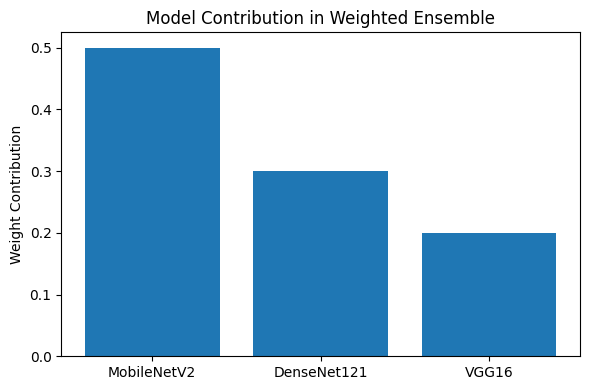

Stacking Ensemble Accuracy: 0.9743

-----------------------------
Ensemble Performance Summary
-----------------------------
Majority Voting Accuracy : 0.9629
Weighted Voting Accuracy : 0.9629
Stacking Accuracy        : 0.9743
-----------------------------


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy.stats import mode

import matplotlib.pyplot as plt

print("Running Ensemble Evaluation...")

test_dir = "K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Test"

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

y_true = test_generator.classes

mobilenet_model = load_model(
    "K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Revised Results/MobileNetV2/model/final_model.keras"
)

densenet_model = load_model(
    "K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Revised Results/DenseNet121/model/final_densenet_model.keras"
)

vgg_model = load_model(
    "K:/ME Project/ME Project/1 New Fish Disease and AquaGPT/Fish Disease/Dataset/Revised Results/VGG16/model/final_vgg16_model.keras"
)

print("Models Loaded")

mobilenet_pred = mobilenet_model.predict(test_generator, verbose=0)
densenet_pred  = densenet_model.predict(test_generator, verbose=0)
vgg_pred       = vgg_model.predict(test_generator, verbose=0)

mb_cls  = np.argmax(mobilenet_pred, axis=1)
dn_cls  = np.argmax(densenet_pred, axis=1)
vgg_cls = np.argmax(vgg_pred, axis=1)

majority_vote, _ = mode(np.vstack([mb_cls, dn_cls, vgg_cls]), axis=0)
majority_vote = majority_vote.flatten()

acc_majority = accuracy_score(y_true, majority_vote)
print("Majority Voting Accuracy:", round(acc_majority, 4))

weights = [0.5, 0.3, 0.2] 

weighted_pred = (
    mobilenet_pred * weights[0] +
    densenet_pred  * weights[1] +
    vgg_pred       * weights[2]
)

weighted_vote = np.argmax(weighted_pred, axis=1)

acc_weighted = accuracy_score(y_true, weighted_vote)
print("Weighted Ensemble Accuracy:", round(acc_weighted, 4))

plt.figure(figsize=(6, 4))
plt.bar(["MobileNetV2", "DenseNet121", "VGG16"], weights)
plt.ylabel("Weight Contribution")
plt.title("Model Contribution in Weighted Ensemble")
plt.tight_layout()
plt.show()


stack_input = np.hstack([mobilenet_pred, densenet_pred, vgg_pred])
meta_preds = np.zeros(len(y_true))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(stack_input, y_true):
    meta = LogisticRegression(max_iter=500)
    meta.fit(stack_input[train_idx], y_true[train_idx])
    meta_preds[test_idx] = meta.predict(stack_input[test_idx])

acc_stacking = accuracy_score(y_true, meta_preds)
print("Stacking Ensemble Accuracy:", round(acc_stacking, 4))


print("\n-----------------------------")
print("Ensemble Performance Summary")
print("-----------------------------")
print("Majority Voting Accuracy :", round(acc_majority, 4))
print("Weighted Voting Accuracy :", round(acc_weighted, 4))
print("Stacking Accuracy        :", round(acc_stacking, 4))
print("-----------------------------")


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

def mcnemar_p_value(pred_probs_A, pred_probs_B, y_true, modelA_name, modelB_name):

    pred_A = np.argmax(pred_probs_A, axis=1)
    pred_B = np.argmax(pred_probs_B, axis=1)

    contingency = np.zeros((2, 2))

    for t, p1, p2 in zip(y_true, pred_A, pred_B):
        contingency[int(p1 == t)][int(p2 == t)] += 1

    result = mcnemar(contingency, exact=False, correction=True)

    print("\n--------------------------------------------------")
    print(f"P-value Comparison: {modelA_name} vs {modelB_name}")
    print("Contingency Table:")
    print(contingency)
    print(f"P-value = {result.pvalue:.5f}")

    if result.pvalue < 0.05:
        print("Conclusion: Difference is statistically significant (p < 0.05)")
    else:
        print("Conclusion: No statistical difference (p ≥ 0.05)")
    print("--------------------------------------------------")


mcnemar_p_value(mobilenet_pred, densenet_pred, y_true, "MobileNetV2", "DenseNet121")
mcnemar_p_value(mobilenet_pred, vgg_pred, y_true, "MobileNetV2", "VGG16")
mcnemar_p_value(densenet_pred, vgg_pred, y_true, "DenseNet121", "VGG16")



--------------------------------------------------
P-value Comparison: MobileNetV2 vs DenseNet121
Contingency Table:
[[233.  40.]
 [ 60.  17.]]
P-value = 0.05743
Conclusion: No statistical difference (p ≥ 0.05)
--------------------------------------------------

--------------------------------------------------
P-value Comparison: MobileNetV2 vs VGG16
Contingency Table:
[[  3. 270.]
 [  1.  76.]]
P-value = 0.00000
Conclusion: Difference is statistically significant (p < 0.05)
--------------------------------------------------

--------------------------------------------------
P-value Comparison: DenseNet121 vs VGG16
Contingency Table:
[[  4. 289.]
 [  0.  57.]]
P-value = 0.00000
Conclusion: Difference is statistically significant (p < 0.05)
--------------------------------------------------
